# **Reinforcement Learning**

- Reinforcement Learning is a type of machine learning in which an agent learns to make decisions by interacting with an enviroment.

1) An agent is an entity that interacts with an enviroment in order to learn how to make decisions that will maximize a specific goal or objective. The agent can be thought of as an autonomous decision-making entity that receives inputs from the environment, performs actions, and receives rewards or penalties based on its actions.

2) The enviroment, on the other hand, is the external system or context in which the agent operates. The environment can be a simulation, a physical system, or any other system that the agent interacts with. The enviroment provides feedback to the agent in the form of rewards or punishments, which the agent uses to learn how to make better decisions.

3) THe agent receives feedback in the form of rewards or penalties, and its goal is to maximize the total reward it receives over time.

4) The agent follows a trial-and-error process of taking actions, observing the consequences, and adjusting its behavior based on the rewards it receives. Over time, the agent learns to identify the actions that lead to the highest rewards and avoids those that lead to penalties.

5) RL agents can adapt to new situations and enviroments. They can adjust their behavior based on the feedback they receive and can continually improve their performance over time.

6) RL agents can learn to optimize their behavior over time, leading to more efficient decision-making and better performance. 

## **Gymnasium Lib** 

- For this project Gymnasium Library and its enviroments is used. It provides a collenton of enviroments or "tasks" that can be used to test and develop RL algorithms. These enviroments are typically game-like, with well-defined rules and reward structure, making them useful for evaluating and comparing different RL algorithms.

- The Gym toolkit includes a set of interfaces and tools for interacting with the enviroments, such as observation spaces, action spaces, and rewards. This makes it easy to build and test RL algorithms is a standardied way.

- These env range from simple games, like Pong or Breakout, to more complex simulations, like robotics and autonomous driving. Gym enviroments are designed to be easy to use and come with a standard interface for interacting with the enviroment.

- To get start with Gym : 

        1) Define the enviroment you want to work with.
        2) CReate an instance of the env.
        3) Define the agent's policy (how it decides which action to take)
        4) Interact with the envviroment, taking actions and receiving rewards
        5) Update the agent's policy based on the rewards it receives. 
        6) Repeat steps 4 and 5 until agent's performance is satisfactory 

# **First Project : Solving Blackjack with Q-Learning**

**Objective**: To win, your card sum should be greater than the dealers without exceeding 21.

**Actions**: Agents can pick between two actions:

- stand (0): the player takes no more cards
- hit (1): the player will be given another card, however the player could get over 21 and bust

**Approach**: To solve this environment by yourself, you can pick your favorite discrete RL algorithm. The presented solution uses Q-learning (a model-free RL algorithm).

In [1]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
%matplotlib inline

In [2]:
import gymnasium as gym
from gymnasium import Env, Wrapper, error, logger

In [3]:
env = gym.make('Blackjack-v1', sab=True, render_mode="rgb")

c:\Users\Altair\AppData\Local\Programs\Python\Lib\site-packages\gymnasium\envs\registration.py:788: UserWarning: WARN: The environment is being initialised with render_mode='rgb' that is not in the possible render_modes (['human', 'rgb_array']).
  logger.warn(


In [4]:
# Observing the environment 

# Reset the enviroment to get the first observation
done = False
Observation, info = env.reset()

#observation = (16,9,False)

Note that our observation s a tuple consisting of 3 values:

1) The players current sum
2) Values of the dealers face-up card
3) Boolean whether the player holds a usable ace (An ace is usable if it counts as 11 without busting)

## **Executing an action**

After receiving our first observation, we are only going to use the env.step(action) function to interact with the environment. This function takes an action as input and executes it in the environment. Because that action changes the state of the environment, it returns four useful variables to us. These are:

    - next_state: This is the observation that the agent will receive after taking the action.
    - reward: This is the reward that the agent will receive after taking the action.
    - terminated: This is a boolean variable that indicates whether or not the environment has terminated.
    - truncated: This is a boolean variable that also indicates whether the episode ended by early truncation, i.e., a time limit is reached.
    - info: This is a dictionary that might contain additional information about the environment.

The next_state, reward, terminated and truncated variables are self-explanatory, but the info variable requires some additional explanation. This variable contains a dictionary that might have some extra information about the environment, but in the Blackjack-v1 environment you can ignore it. For example in Atari environments the info dictionary has a ale.lives key that tells us how many lives the agent has left. If the agent has 0 lives, then the episode is over.

Note that it is not a good idea to call env.render() in your training loop because rendering slows down training by a lot. Rather try to build an extra loop to evaluate and showcase the agent after training.

In [5]:
# sample a random action from all valid actions
action = env.action_space.sample()
# action=1

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)

# observation=(24, 10, False)
# reward=-1.0
# terminated=True
# truncated=False
# info={}

Once terminated = True or truncated=True, we should stop the current episode and begin a new one with env.reset(). If you continue executing actions without resetting the environment, it still responds but the output won’t be useful for training (it might even be harmful if the agent learns on invalid data).

## **Bulding an agent**

Let’s build a Q-learning agent to solve Blackjack-v1! We’ll need some functions for picking an action and updating the agents action values. To ensure that the agents explores the environment, one possible solution is the epsilon-greedy strategy, where we pick a random action with the percentage epsilon and the greedy action (currently valued as the best) 1 - epsilon.

In [6]:
class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

To train the agent, we will let the agent play one episode (one complete game is called an episode) at a time and then update it’s Q-values after each episode. The agent will have to experience a lot of episodes to explore the environment sufficiently.

Now we are ready to build the training loop.

In [7]:
# hyperparameters
learning_rate = 0.01 *0.1
n_episodes = 100_000 * 10
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

Info: The current hyperparameters are set to quickly train a decent agent. If you want to converge to the optimal policy, try increasing the n_episodes by 10x and lower the learning_rate (e.g. to 0.001).

In [8]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|██████████| 1000000/1000000 [08:20<00:00, 1998.08it/s]


## **Results Visualization : For the training** 

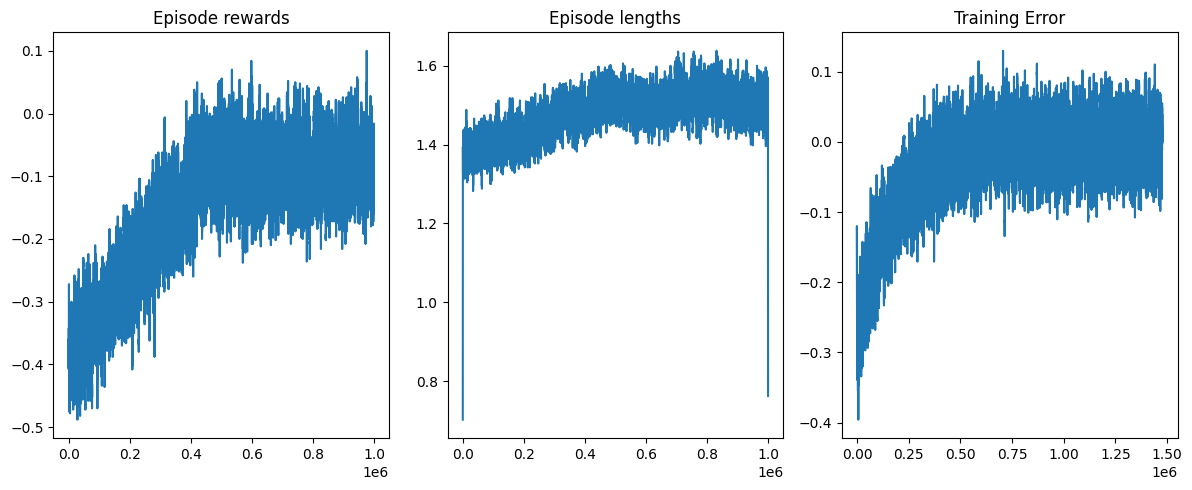

In [9]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

## **Results Visualization : For the policy** 

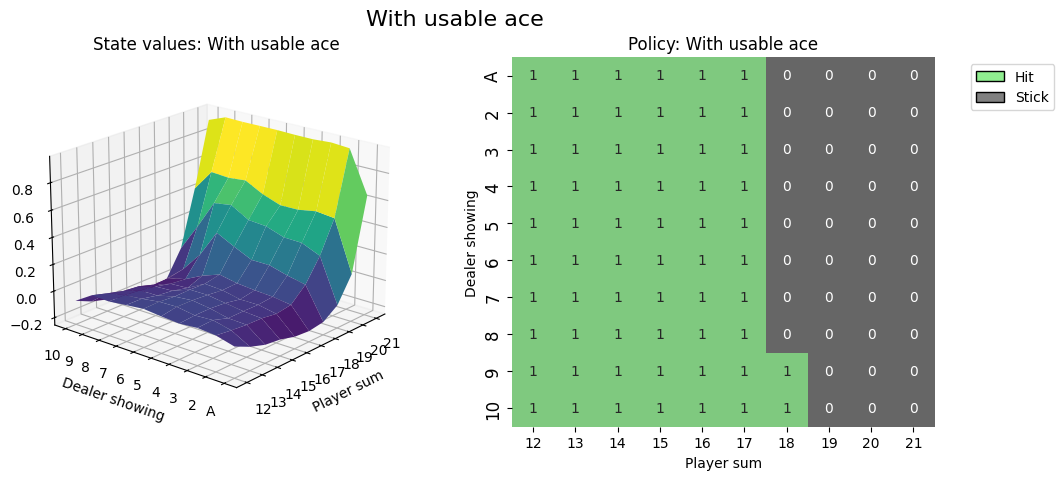

In [10]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

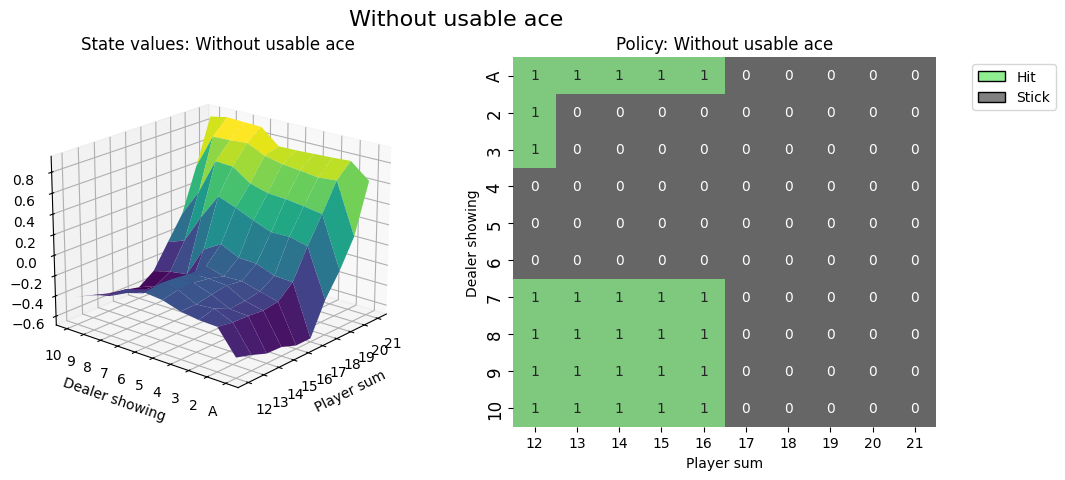

In [11]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

It's good practice to call env.close() at the end of your script, so that any used resources by the environment will be closed.

In [12]:
env.close()